### Logistric Lasso Regression for Feature Selection
Attempt to use L1 regularized logistic regression to predict the winning candidates in each county. Ideally, a good model will only use features that are predictive of who will win and we can zoom in on them for further analysis.

Lesson learned:  
It's important to recognize class imbalances in the data. In the Republican primaries, Trump won >73% of the vote and the model had accuracy of only 73%, so it's practically worthless (could have just guessed Trump 100% of the time).

What does this mean? Maybe we can only predict winners well in swing states/counties. i.e. County demographics are only predictive of winners in swing states.

In [ ]:
import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    f1_score,
    confusion_matrix,
    balanced_accuracy_score,
    precision_score,
    recall_score
    )

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [ ]:
rep = pd.read_csv('Datasets/kaggle-presidential/rep_clean_county_facts.csv')
dem = pd.read_csv('Datasets/kaggle-presidential/dem_clean_county_facts.csv', index_col=0)

In [ ]:
rep.set_index('st_cnty', inplace=True)
dem.set_index('st_cnty', inplace=True)

In [ ]:
def pproc_data(data, test_size=0.2):
    remove_cols = ['state', 'votes', 'fraction_votes', 'unity', 'candidate']
    X = data.loc[:, data.columns[~data.columns.isin(remove_cols)]]
    y = data.candidate
    return train_test_split(X, y, test_size=test_size, stratify=y)

In [ ]:
def logit_train_kfold(X_train, y_train, param_grid, k=10, plot_fts=False):

    kf = StratifiedKFold(n_splits=k, shuffle=True)

    lr_z = make_pipeline(
        StandardScaler(),
        linear_model.LogisticRegression(penalty='l1',
            fit_intercept=False,
            solver='saga',
            multi_class='multinomial',
            max_iter=1e3
            )
    )

    # param_grid = {'logisticregression__C': np.logspace(-2, 2, 20)}
    grid = GridSearchCV(lr_z, param_grid={'logisticregression__C': param_grid}, cv=kf, n_jobs=4)
    grid.fit(X_train, y_train)

    clf = grid.best_estimator_

    print(f'Best validation accuracy: {grid.best_score_*100:.2f}%')
    print(f'Best regularization log10(C): {np.log10(grid.best_params_["logisticregression__C"])}')
    # print(f'Baseline: Trump won 73.9% of counties')

    if plot_fts:
        feature_importance = pd.DataFrame(
            clf.coef_,
            index=y.candidate.factorize()[1],
            columns=X.columns
        )
        fig, ax = plt.subplots(figsize=(15, 8))
        sns.heatmap(
            feature_importance,
            cmap='icefire',
            robust=True,
            center=0,
            cbar_kws={'label': 'Effect Size'},
            ax=ax
        )
        ax.set_yticklabels(
            feature_importance.index, 
            rotation=0, fontsize="10", va="center"
        )

    return clf, grid

In [ ]:
def plot_fts(X_train, y_train, clf):
    feature_importance = pd.DataFrame(
            clf['logisticregression'].coef_,
            index=y_train.factorize()[1],
            columns=X_train.columns
    )
    fig, ax = plt.subplots(figsize=(15, 8))
    sns.heatmap(
        feature_importance,
        cmap='icefire',
        robust=True,
        center=0,
        cbar_kws={'label': 'Effect Size'},
        ax=ax
    )
    ax.set_yticklabels(
        feature_importance.index, 
        rotation=0, fontsize="10", va="center"
    )

### Republican Primaries

In [ ]:
rep_Xtrain, rep_Xtest, rep_ytrain, rep_ytest = pproc_data(rep)
rep_clf, rep_grid = logit_train_kfold(rep_Xtrain, rep_ytrain, param_grid = np.logspace(-2, 2, 20), k=10)

Best validation accuracy: 73.89%
Best regularization log10(C): -0.10526315789473696


In [ ]:
pd.DataFrame(grid.cv_results_)

NameError: name 'grid' is not defined

### Democratic Primaries

In [ ]:
dem_Xtrain, dem_Xtest, dem_ytrain, dem_ytest = pproc_data(dem)

In [ ]:
dem_clf, dem_grid = logit_train_kfold(dem_Xtrain, dem_ytrain, param_grid=np.logspace(-2, 2, 20), k=10)

Best validation accuracy: 73.44%
Best regularization log10(C): 0.10526315789473673


In [ ]:
dem_clf.score(dem_Xtest, dem_ytest)

0.7397504456327986

In [ ]:
f1_score(dem_ytest, dem_clf.predict(dem_Xtest), average='weighted')

0.7395222087781335

<AxesSubplot:>

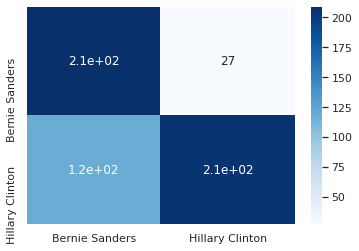

In [ ]:
sns.heatmap(confusion_matrix(dem_ytest, dem_clf.predict(dem_Xtest)), cmap='Blues', annot=True,
xticklabels=dem_ytrain.factorize()[1],
yticklabels=dem_ytrain.factorize()[1])

In [ ]:
dem_clf.steps[1].coef_

AttributeError: 'tuple' object has no attribute 'coef_'

In [ ]:
dem_clf['logisticregression'].coef_.shape

(1, 15)

In [ ]:
pd.DataFrame(
    dem_clf['logisticregression'].coef_,
    index=[0],
    columns=dem_Xtrain.columns
    )

,income,hispanic,asian,black,white,foreign,college,density,vets,female,senior,children,population (2014),total_votes,voter_turnout
0,0.232747,0.629905,0.142221,1.113806,0.33598,-0.152147,-0.39217,0.164741,0.104224,0.171358,0.192015,0.004192,-0.272893,0.330361,-0.310441


In [ ]:
plot_fts(dem_Xtrain, dem_ytrain, dem_clf)

ValueError: Shape of passed values is (1, 15), indices imply (2, 15)

### Ignore

In [ ]:
# f1_score(y_test, model.predict(X_test_scaled), average='macro')

0.4421005594806211

In [ ]:
# balanced_accuracy_score(y_test, model.predict(X_test_scaled))

0.4819912570985006

In [ ]:
# precision_score(y_test, model.predict(X_test_scaled), average='macro')

0.4526641751244953

In [ ]:
# recall_score(y_test, model.predict(X_test_scaled), average='macro')

0.4819912570985006

<AxesSubplot:>

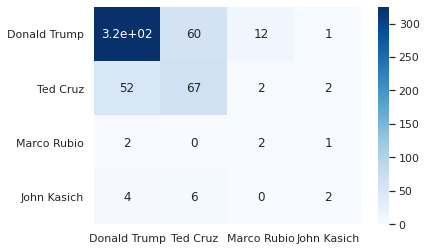

In [ ]:
# sns.heatmap(confusion_matrix(y_test, model.predict(X_test_scaled)), xticklabels=feature_importance.index, yticklabels=feature_importance.index,
# cmap='Blues', annot=True)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6db671ff-4b94-4ec9-9d8f-30a849bb0caf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>